This notebook contains code for the initial work to explore different Linear regression Models on our data set. The result were near perfect models. We were ab

##Package Imports mount gdrive

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read the data from database

In [2]:
# Connect to SQLite database
conn = sqlite3.connect('/content/drive/MyDrive/CIS5450/Term_Project/data/db_model')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Query to retrieve all rows from the 'model' table
query = "SELECT * FROM model;"

# Execute the query and fetch the results
try:
    df = pd.read_sql_query(query, conn)
    print("Data successfully loaded into DataFrame.")
    # Display the DataFrame
except Exception as e:
    print("Error:", e)
finally:
    # Close the connection
    conn.close()

Data successfully loaded into DataFrame.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66771 entries, 0 to 66770
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   airbnb_price                    66771 non-null  float64
 1   minimum_nights                  66771 non-null  int64  
 2   number_of_reviews               66771 non-null  int64  
 3   last_review                     50686 non-null  object 
 4   reviews_per_month               66771 non-null  float64
 5   num_listings                    66771 non-null  int64  
 6   price                           66771 non-null  float64
 7   cost_fl_area                    66771 non-null  float64
 8   income-rankavgscore             66771 non-null  int64  
 9   health-rankavgscore             66771 non-null  int64  
 10  crime-rankavgscore              66771 non-null  int64  
 11  housebar-rankavgscore           66771 non-null  int64  
 12  env-rankavgscore                

### Drop null values and rename columns

In [7]:
main_df = df.drop(['last_review'], axis=1)


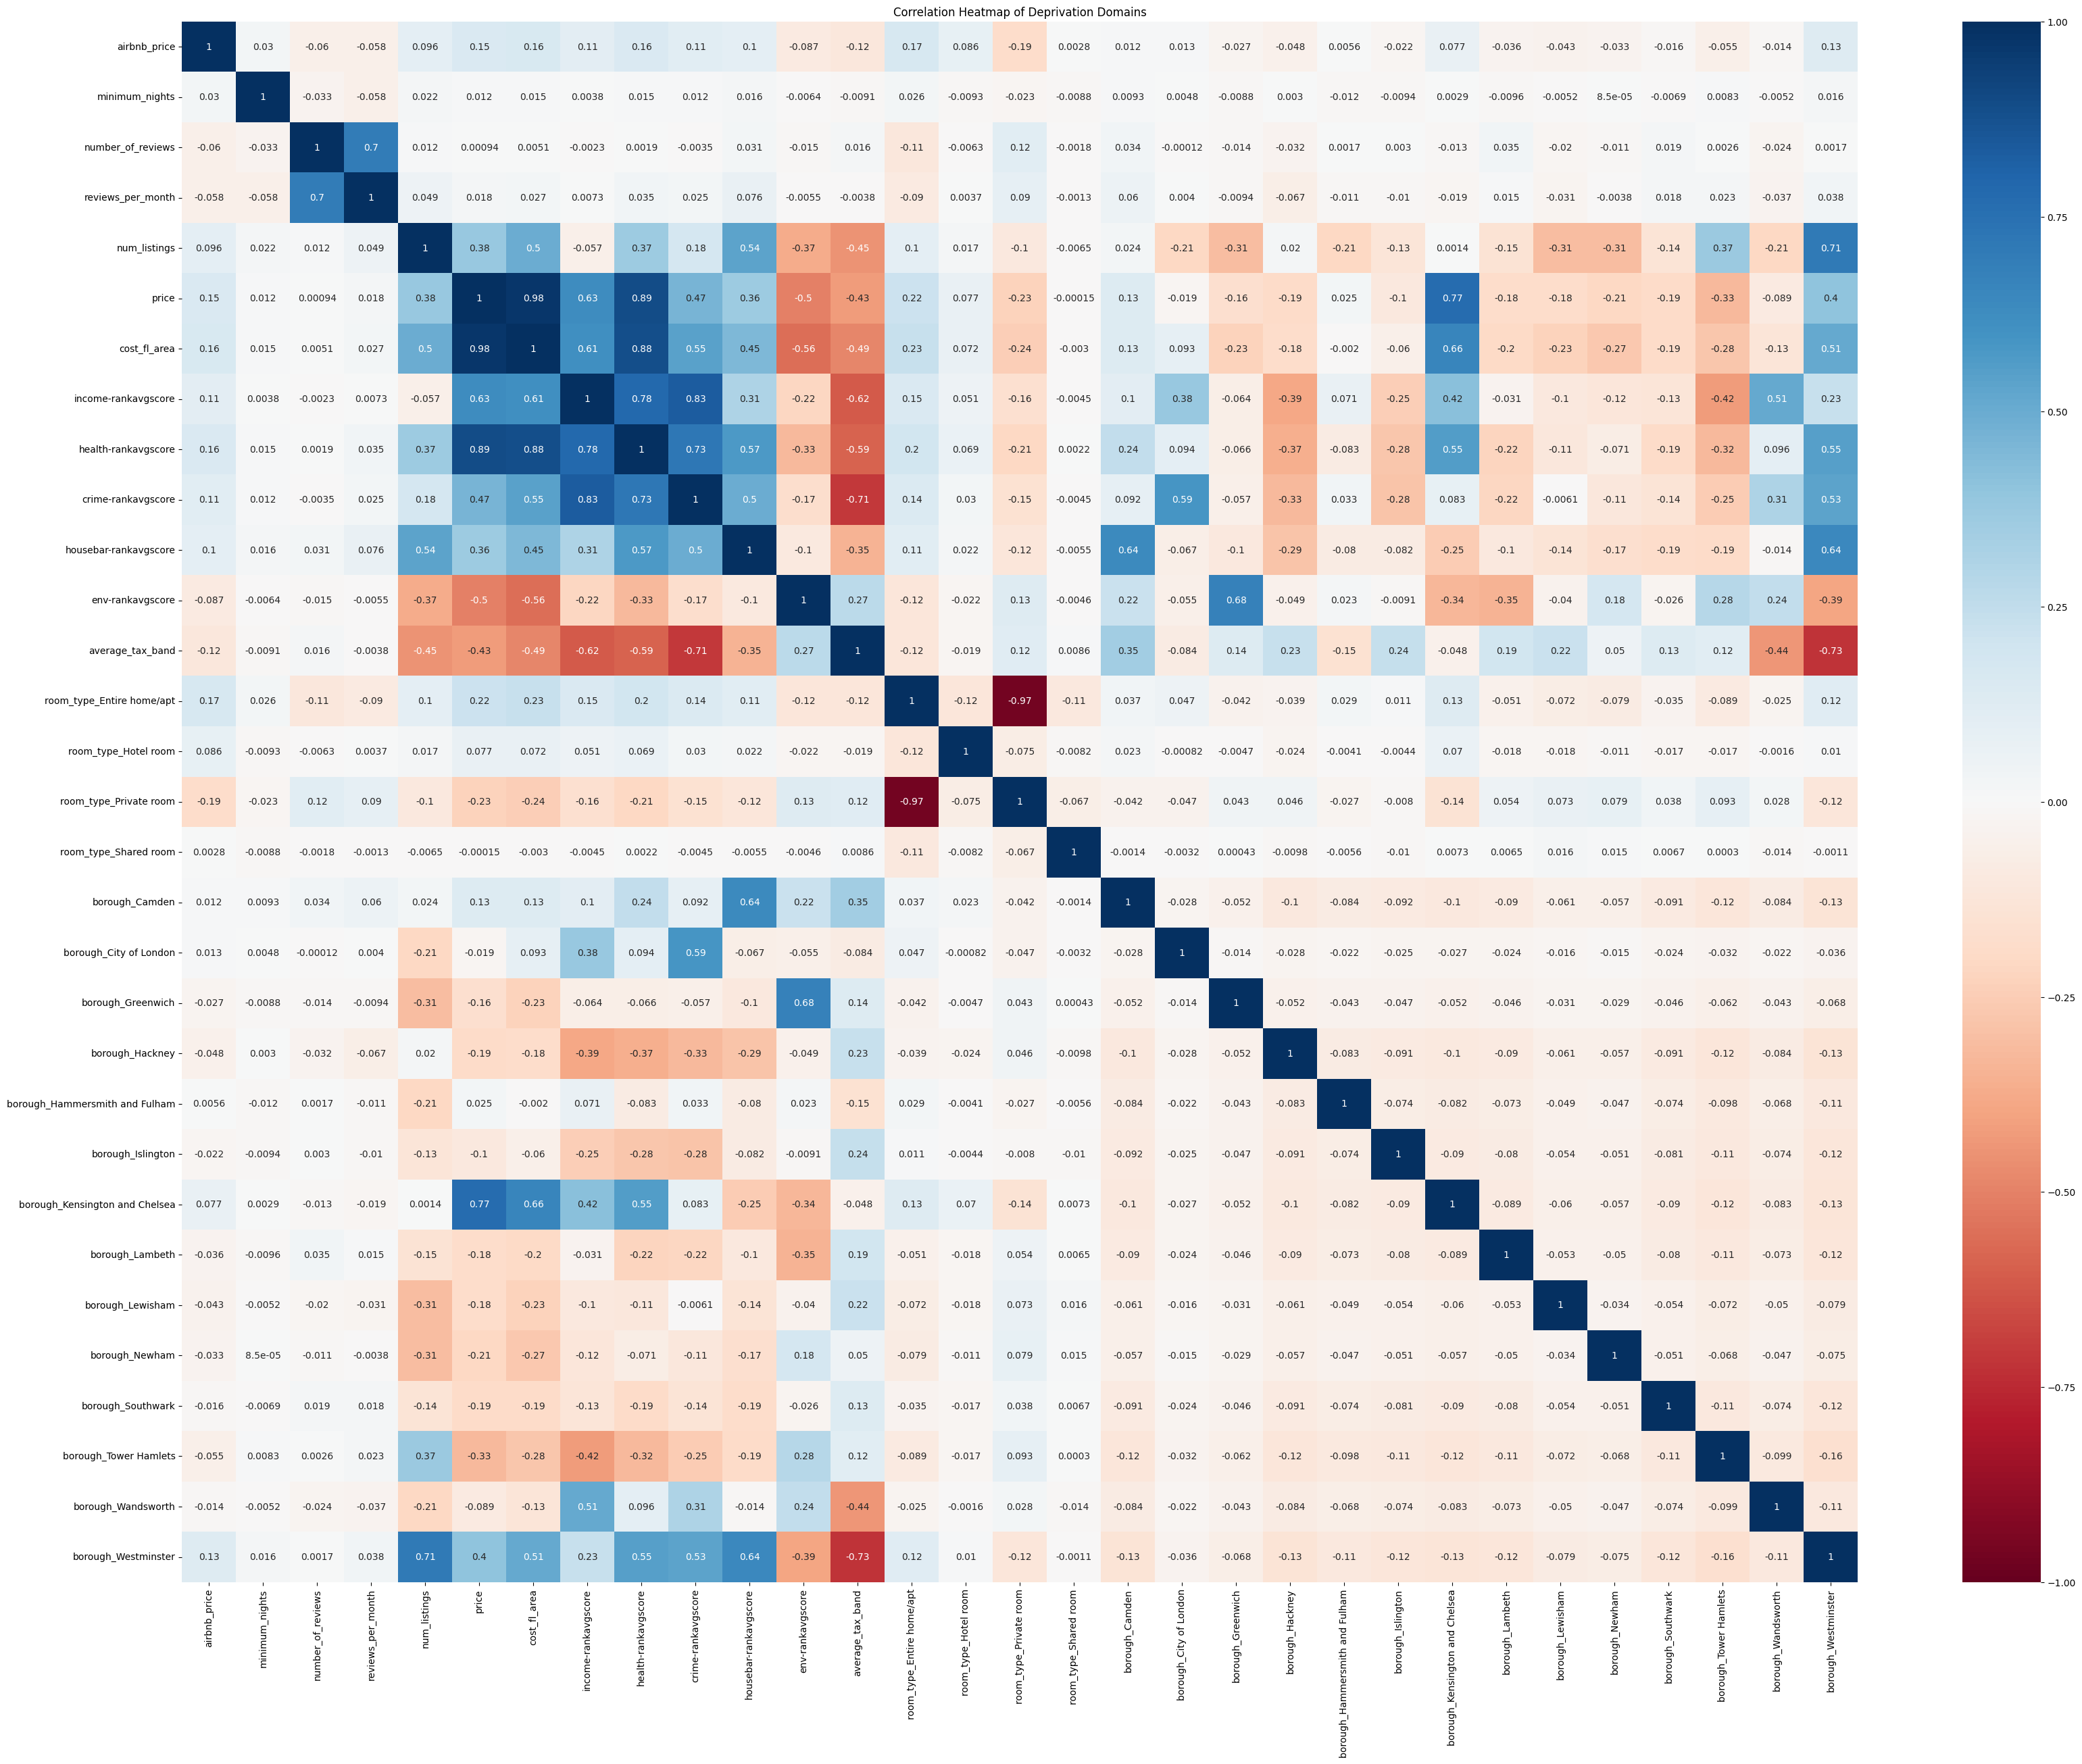

In [8]:
correlation_matrix = main_df.corr()

plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmax=1,vmin = -1)
plt.title('Correlation Heatmap of Deprivation Domains')
plt.show()

In [9]:
main_df = main_df.drop(['price'], axis=1)
main_df = main_df.drop(['room_type_Entire home/apt'], axis=1)
main_df = main_df.drop(['room_type_Hotel room'], axis=1)
main_df = main_df.rename(columns={ "room_type_Private room": "room_type_Private", "room_type_Shared room": "room_type_Shared"})
main_df.columns

Index(['airbnb_price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'num_listings', 'cost_fl_area',
       'income-rankavgscore', 'health-rankavgscore', 'crime-rankavgscore',
       'housebar-rankavgscore', 'env-rankavgscore', 'average_tax_band',
       'room_type_Private', 'room_type_Shared', 'borough_Camden',
       'borough_City of London', 'borough_Greenwich', 'borough_Hackney',
       'borough_Hammersmith and Fulham', 'borough_Islington',
       'borough_Kensington and Chelsea', 'borough_Lambeth', 'borough_Lewisham',
       'borough_Newham', 'borough_Southwark', 'borough_Tower Hamlets',
       'borough_Wandsworth', 'borough_Westminster'],
      dtype='object')

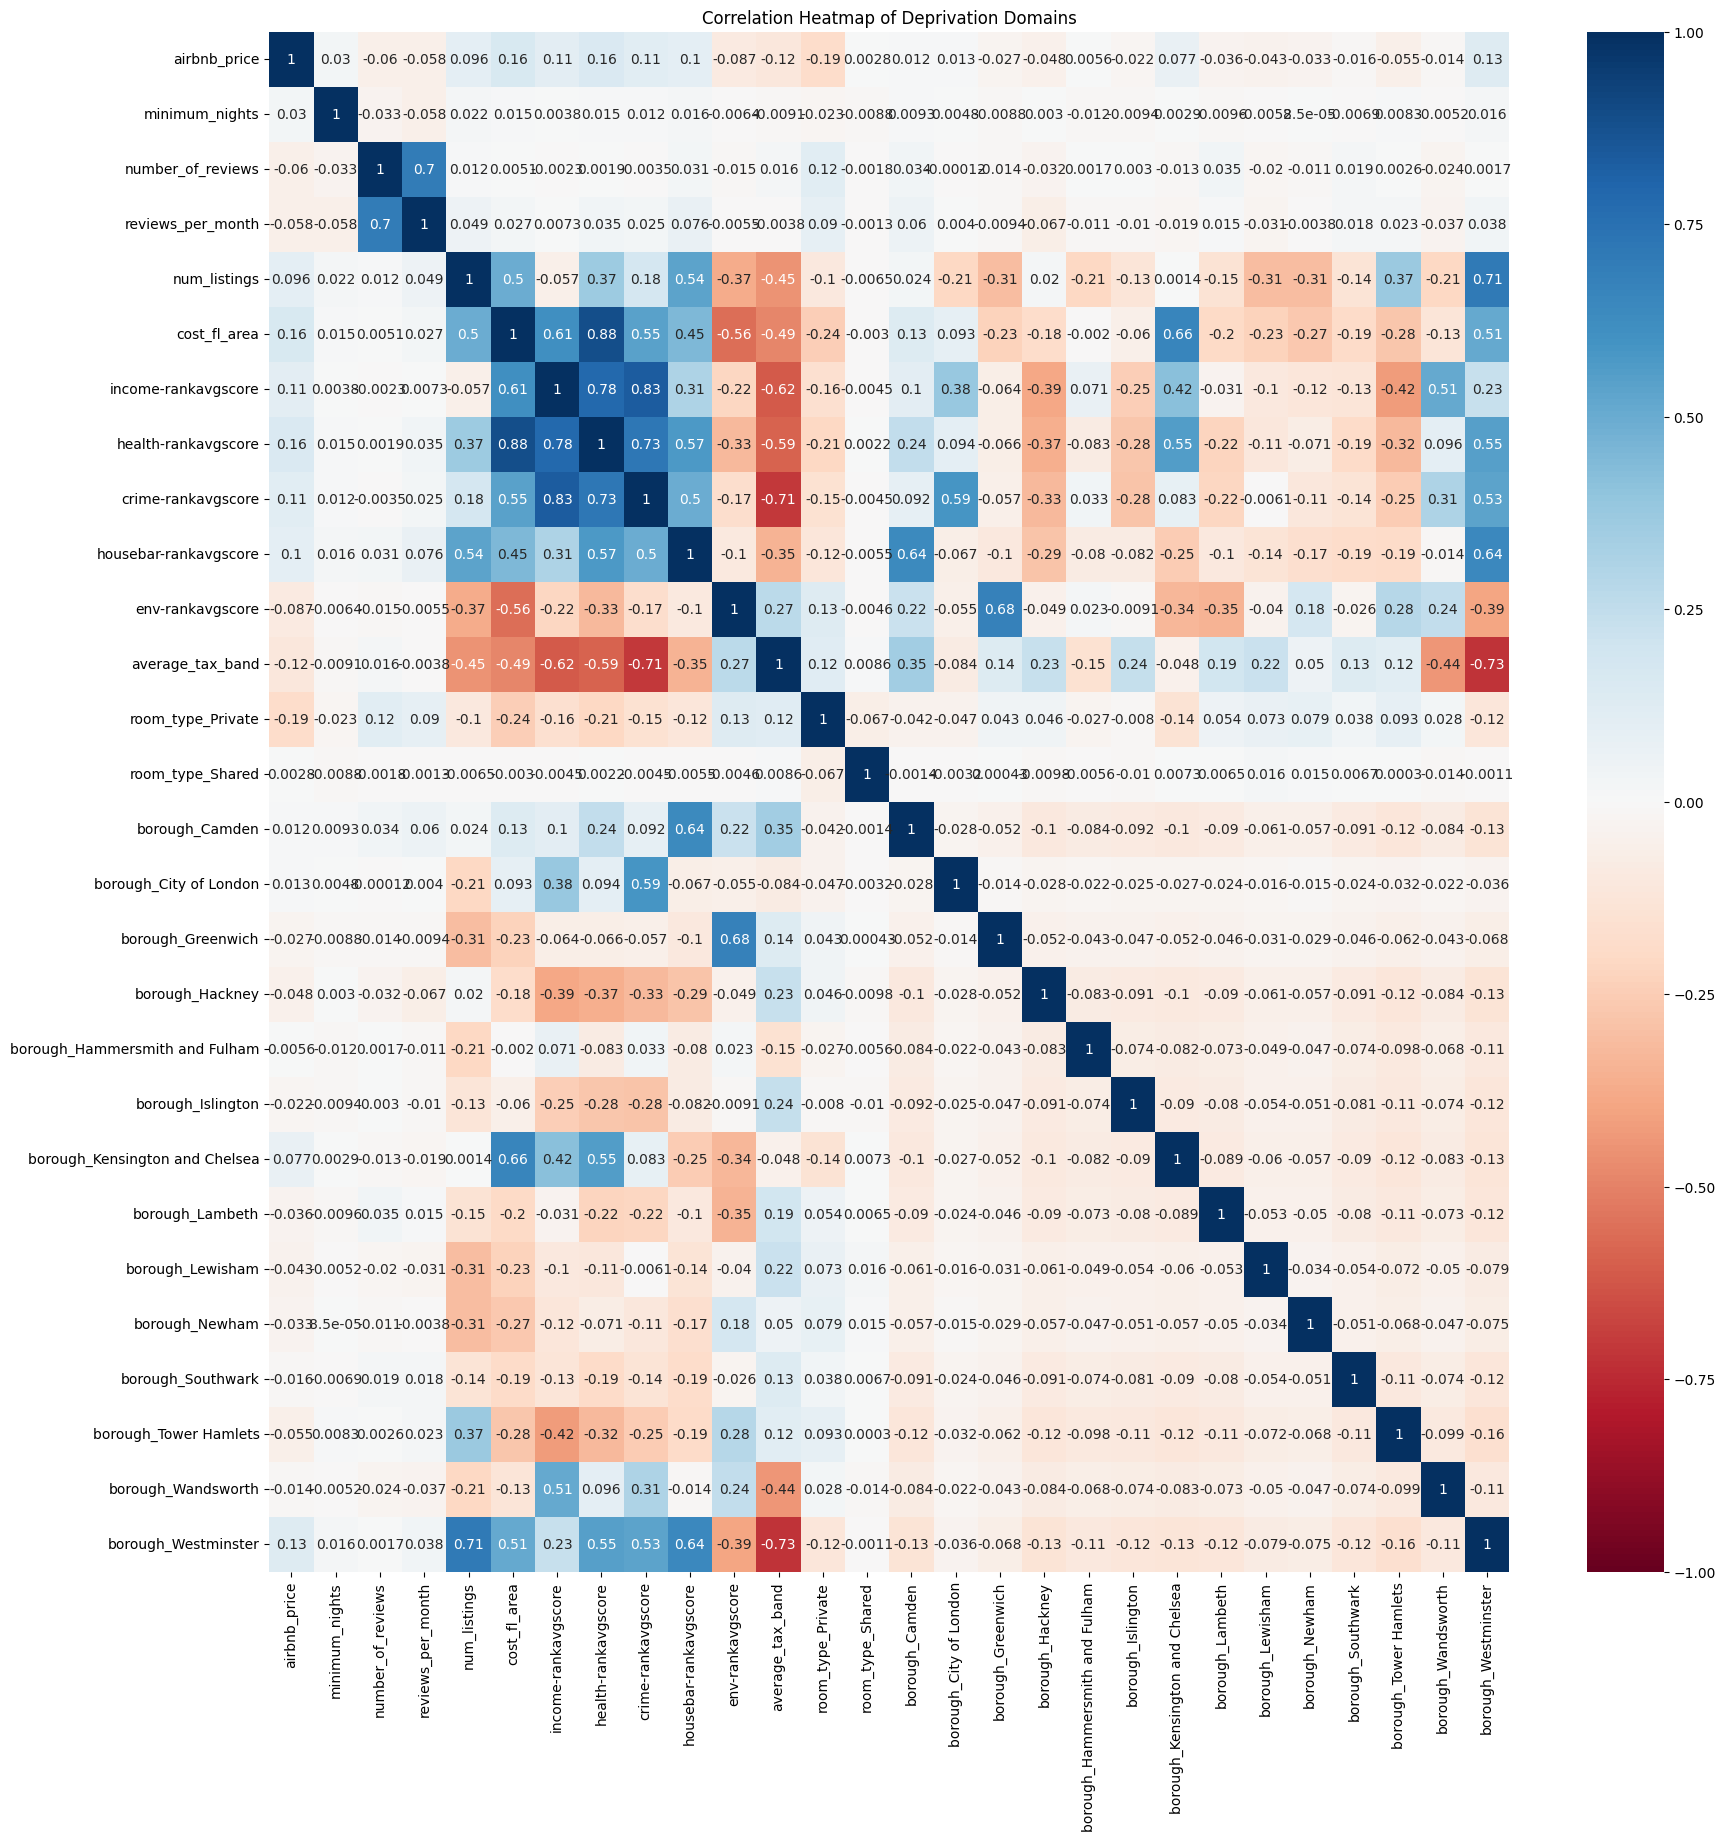

In [10]:
correlation_matrix = main_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmax=1,vmin = -1)
plt.title('Correlation Heatmap of Deprivation Domains')
plt.show()

<h1>Unsupervised Learning </h1>


# Split the training data and testing data
Number of airbnb listings (num_listings) and number of reviews (number_of_reviews) are feature columns, will be treated as X.

We won't be scaling the data, for now as our first model will be a random forest, which is scale invariant.

80% of the data will be used for training, 20% of the data will be used for testing.

In [11]:

X_filtered = main_df


_**Initial PCA**_


In [12]:
features = X_filtered.copy()

#target = features['price'].astype(int)
#features = features.drop(['price'], axis=1)

target = features['cost_fl_area'].astype(int)
features = features.drop(['cost_fl_area'], axis=1)

# split into test/train
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

PCA is not scale invariant, so we need to standardize the features.

In [14]:
scaller = StandardScaler() # scaller object

X_trained  = scaller.fit_transform(X_train) #scalling train data

pca = PCA() #pca object
X_trained_pca = pca.fit_transform(X_trained)#applying to scaled training data

Cumulative Explained Variance Ratios

In [15]:
# Save the explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Save the CUMULATIVE explained variance ratios
cum_evr = np.cumsum(pca.explained_variance_ratio_)

In [16]:
explained_variance_ratios
cum_evr

array([0.18205743, 0.2720796 , 0.3471476 , 0.41236746, 0.473994  ,
       0.5245568 , 0.5687418 , 0.61199935, 0.65369481, 0.69430505,
       0.7342718 , 0.77413661, 0.81340922, 0.85180764, 0.889279  ,
       0.9262718 , 0.96071398, 0.98901052, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

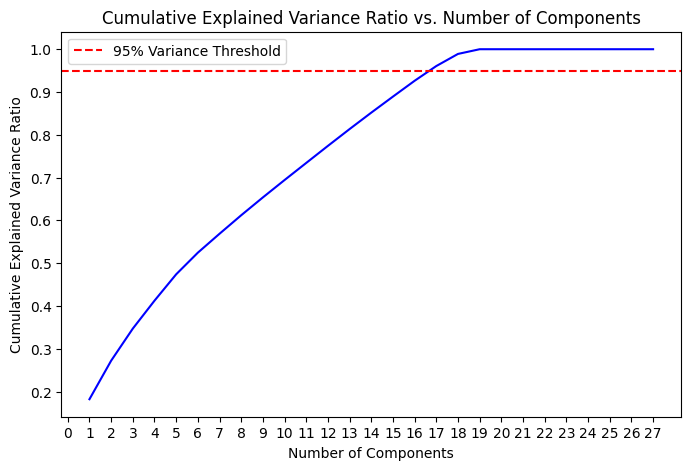

In [17]:
# To find optimal num components to use
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cum_evr)+1 ), cum_evr, color='b')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.legend()
plt.xticks(np.arange(len(cum_evr)+1))
plt.show()

In [18]:
# [TODO] How many components do we need to explain 95% of the variance?
cum = np.cumsum(explained_variance_ratios)
np.where(cum > 0.95)[0][0]

16

_**Final PCA**_



In [19]:
# Refit and transform on training with parameter n (as deduced from the last step)
pca_17 = PCA(n_components=16)

X_train_pca = pca_17.fit_transform(X_trained) # update trained pca

# Transform on Testing Set and store it as `X_test_pca`
X = scaller.transform(X_test)
X_test_pca = pca_17.transform(X)


In [20]:
X_test_pca

array([[ 0.86038142, -0.20539395,  2.55578404, ...,  0.22787199,
         0.2222039 , -0.20629461],
       [ 2.0520029 ,  2.98655531,  0.49687335, ..., -0.30705692,
         1.05724392,  0.51578911],
       [ 1.80194832,  1.09303012, -2.3778263 , ...,  0.04015439,
        -0.40670039,  0.25719753],
       ...,
       [-1.60639138,  0.23431231, -0.54110629, ..., -0.03522137,
        -0.72248576, -0.62668624],
       [ 3.83158849, -1.63769209, -0.0447938 , ..., -0.13636556,
        -0.14834379, -0.22359397],
       [ 1.8020668 ,  2.98176728,  0.77757336, ..., -0.23629233,
         0.64201827,  0.63367498]])

Log reg over pca

Score: 0.9511943933944392
MAE: 485.8740924227413
MSE: 467118.86118844023
RMSE: 683.4609434257676


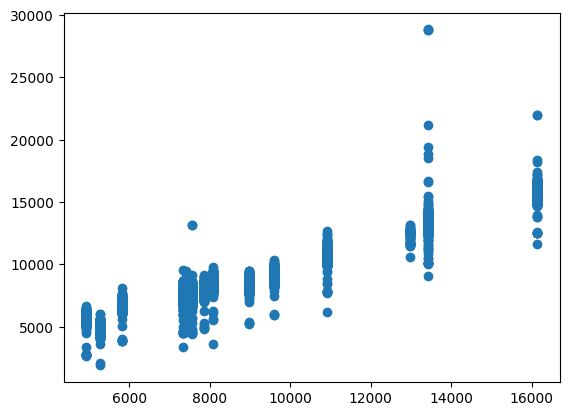

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

clf = LinearRegression()
clf.fit(X_train_pca, y_train)

predictions = clf.predict(X_test_pca)

print("Score:", clf.score(X_test_pca, y_test))
plt.figure()
plt.scatter(y_test, predictions)
#plt.scatter(y_test)
# Different error measures
print("MAE:", mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

In [26]:
features = X_filtered.copy()

In [27]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66771 entries, 0 to 66770
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   airbnb_price                    66771 non-null  float64
 1   minimum_nights                  66771 non-null  int64  
 2   number_of_reviews               66771 non-null  int64  
 3   reviews_per_month               66771 non-null  float64
 4   num_listings                    66771 non-null  int64  
 5   cost_fl_area                    66771 non-null  float64
 6   income-rankavgscore             66771 non-null  int64  
 7   health-rankavgscore             66771 non-null  int64  
 8   crime-rankavgscore              66771 non-null  int64  
 9   housebar-rankavgscore           66771 non-null  int64  
 10  env-rankavgscore                66771 non-null  int64  
 11  average_tax_band                66771 non-null  float64
 12  room_type_Private               

In [28]:

target = features['cost_fl_area'].astype(int)
features = features.drop(['cost_fl_area'], axis=1)

# split into test/train
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46739 entries, 48838 to 28520
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   airbnb_price                    46739 non-null  float64
 1   minimum_nights                  46739 non-null  int64  
 2   number_of_reviews               46739 non-null  int64  
 3   reviews_per_month               46739 non-null  float64
 4   num_listings                    46739 non-null  int64  
 5   income-rankavgscore             46739 non-null  int64  
 6   health-rankavgscore             46739 non-null  int64  
 7   crime-rankavgscore              46739 non-null  int64  
 8   housebar-rankavgscore           46739 non-null  int64  
 9   env-rankavgscore                46739 non-null  int64  
 10  average_tax_band                46739 non-null  float64
 11  room_type_Private               46739 non-null  int64  
 12  room_type_Shared            

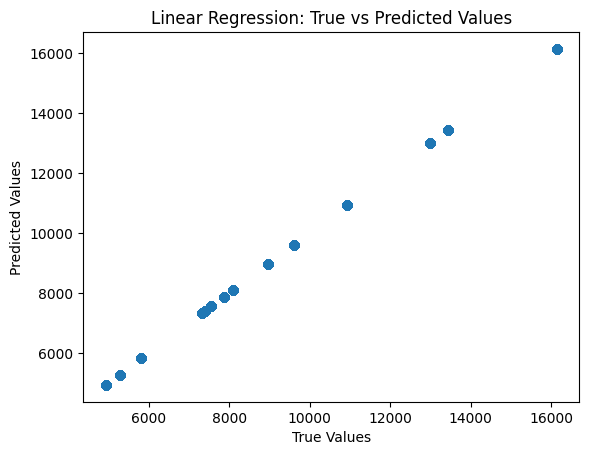

Linear Regression Root Mean Squared Error (RMSE): 7.025633457303947e-11
R-squared score: 1.0
Linear Regression Mean Squared Error (MSE): 4.935952547638861e-21
Linear Regression Mean Absolute Error (MAE): 5.312462433041579e-11
Linear Regression Explained Variance Score: 1.0


In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error,explained_variance_score


linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

#Use the model to predict on the test set
prediction = linear_reg_model.predict(X_test)


plt.scatter(y_test, prediction)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: True vs Predicted Values")
plt.show()


# Root Mean Squared Error (RMSE)
linear_reg_rmse = np.sqrt(mean_squared_error(y_test, prediction))
print("Linear Regression Root Mean Squared Error (RMSE):", linear_reg_rmse)


#Find the R-squared score
lin_reg_score = linear_reg_model.score(X_test, y_test)
print("R-squared score:", lin_reg_score)

# Calculate Mean Squared Error (MSE)
linear_reg_mse = mean_squared_error(y_test, prediction)
print("Linear Regression Mean Squared Error (MSE):", linear_reg_mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, prediction)
print("Linear Regression Mean Absolute Error (MAE):", mae)

# Calculate Explained Variance Score:
evs = explained_variance_score(y_test, prediction)
print("Linear Regression Explained Variance Score:", evs)

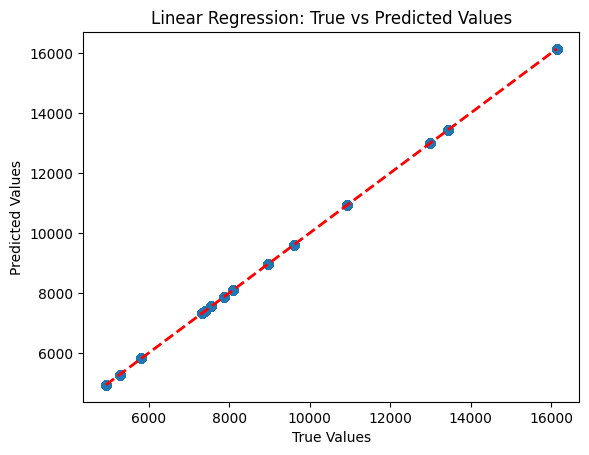

In [31]:
plt.scatter(y_test, prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: True vs Predicted Values")
plt.show()

Lasso Regression R-squared: 0.9999998026574886
Lasso Regression MSE: 1.9352980019877004
Lasso Regression RMSE: 1.3911498848031079
Lasso Regression RMSE: 1.3911498848031079
Linear Regression Explained Variance Score: 0.9999998026607335


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.328e+07, tolerance: 4.540e+07
  model = cd_fast.enet_coordinate_descent(


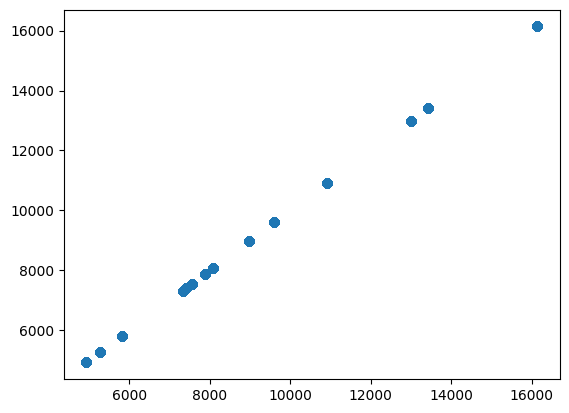

In [32]:
from sklearn.linear_model import Lasso

# Lasso Regression model
lasso_model = Lasso(alpha=0.1)  # You can adjust the alpha parameter
lasso_model.fit(X_train, y_train)

lasso_predictions = lasso_model.predict(X_test)


#Find the R-squared score and store the value in `lasso_score`
lasso_score = lasso_model.score(X_test, y_test)
print("Lasso Regression R-squared:", lasso_score)

# Compute Mean Squared Error (MSE) for Lasso regression
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("Lasso Regression MSE:", lasso_mse)

# Compute Root Mean Squared Error (RMSE) for Lasso regression
lasso_rmse = np.sqrt(lasso_mse)
print("Lasso Regression RMSE:", lasso_rmse)


lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_predictions))
print("Lasso Regression RMSE:", lasso_rmse)

evs = explained_variance_score(y_test, lasso_predictions)
print("Linear Regression Explained Variance Score:", evs)

plt.figure()
plt.scatter(y_test, prediction)

Lasso Regression R-squared: 0.9999999857290126
Lasso Regression MSE: 0.13995267972577977
Lasso Regression RMSE: 0.3741024989568765
lass Regression Root Mean Squared Error (RMSE): 0.3741024989568765
Linear Regression Explained Variance Score: 0.9999999857295003


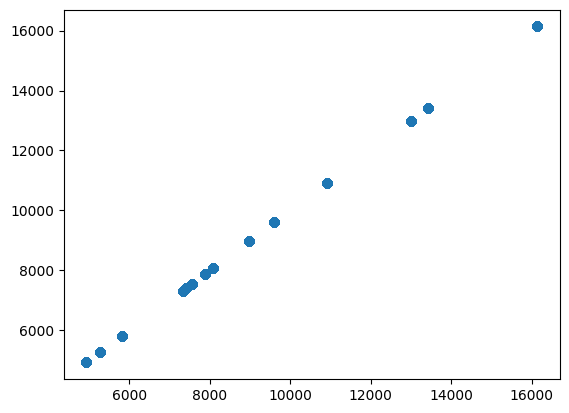

In [33]:
from sklearn.linear_model import Lasso

scal = StandardScaler()
X_scalled  = scal.fit_transform(X_train)
X_test_scalled  = scal.transform(X_test)

# TO-DO: Initialize Lasso model with alpha = 0.1 (adjust alpha based on your needs)
reg_lasso = Lasso(alpha=0.1).fit(X_scalled, y_train)

# TO-DO: Use the Lasso model to predict on the test set and save these predictions as `y_pred_lasso`
y_pred_lasso = reg_lasso.predict(X_test_scalled)

# TO-DO: Find the R-squared score and store the value in `lasso_score`
lasso_score = reg_lasso.score(X_test_scalled, y_test)
print("Lasso Regression R-squared:", lasso_score)

# Compute Mean Squared Error (MSE) for Lasso regression
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
print("Lasso Regression MSE:", lasso_mse)

# Compute Root Mean Squared Error (RMSE) for Lasso regression
lasso_rmse = np.sqrt(lasso_mse)
print("Lasso Regression RMSE:", lasso_rmse)


# Root Mean Squared Error (RMSE)
linear_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print("lass Regression Root Mean Squared Error (RMSE):", linear_reg_rmse)

evs = explained_variance_score(y_test, y_pred_lasso)
print("Linear Regression Explained Variance Score:", evs)

plt.figure()
plt.scatter(y_test, prediction)

In [34]:
# Ridge Regression model

ridge_model = Ridge(alpha=1.0)  # You can adjust the alpha parameter
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_predictions))
print("Ridge Regression RMSE:", ridge_rmse)

Ridge Regression RMSE: 0.34068869006866126


In [35]:
# TO-DO: Intermediate step to address scale-invariance
from sklearn.preprocessing import StandardScaler

scal = StandardScaler()
X_scalled  = scal.fit_transform(X_train)
X_test_scalled  = scal.transform(X_test)



from sklearn.linear_model import Ridge


reg_ridge = Ridge(alpha=10).fit(X_scalled, y_train)

y_pred = reg_ridge.predict(X_test_scalled)


ridge_score = reg_ridge.score(X_test_scalled, y_test)
print(ridge_score)

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Compute Mean Squared Error (MSE)
ridge_mse = mean_squared_error(y_test, y_pred)
print("Ridge Regression MSE:", ridge_mse)

# Compute Root Mean Squared Error (RMSE)
ridge_rmse = np.sqrt(ridge_mse)
print("Ridge Regression RMSE:", ridge_rmse)

# Compute R-squared
ridge_r2 = r2_score(y_test, y_pred)
print("Ridge Regression R-squared:", ridge_r2)

0.9999999887936111
Ridge Regression MSE: 0.10989878458330103
Ridge Regression RMSE: 0.33150985593689525
Ridge Regression R-squared: 0.9999999887936111


In [36]:
from sklearn.linear_model import ElasticNet

# TO-DO: Initialize ElasticNet model with alpha = 0.1 and l1_ratio = 0.5
# Adjust alpha and l1_ratio based on your needs
reg_elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5).fit(X_scalled, y_train)

# TO-DO: Use the ElasticNet model to predict on the test set and save these predictions as `y_pred_elastic_net`
y_pred_elastic_net = reg_elastic_net.predict(X_test_scalled)

# TO-DO: Find the R-squared score and store the value in `elastic_net_score`
elastic_net_score = reg_elastic_net.score(X_test_scalled, y_test)
print("Elastic Net Regression R-squared:", elastic_net_score)

# Compute Mean Squared Error (MSE) for Elastic Net regression
elastic_net_mse = mean_squared_error(y_test, y_pred_elastic_net)
print("Elastic Net Regression MSE:", elastic_net_mse)

# Compute Root Mean Squared Error (RMSE) for Elastic Net regression
elastic_net_rmse = np.sqrt(elastic_net_mse)
print("Elastic Net Regression RMSE:", elastic_net_rmse)


Elastic Net Regression R-squared: 0.9994321848199172
Elastic Net Regression MSE: 5568.448356769105
Elastic Net Regression RMSE: 74.62203666993487
